In [30]:
import tensorflow as tf
import pickle
from util import *
from load_data import load_input_file, build_combined_input
from NN_train import *
path_tosave = 'Models/V05_SvsS_Final_6Vars_without_Total_Charge'
path_SvsS = path_tosave + '/SvsS/'
path_SvsB = path_tosave + '/SvsB/'
mkdir_p(path_tosave)
mkdir_p(path_SvsS)
mkdir_p(path_SvsB)
features_to_ignore = ["DeltaR_min_lep_bjet77", "DeltaR_max_lep_bjet77", "DRjj_lead", "total_charge"]
#features_to_ignore = ["DPhill_SS", "DeltaR_min_lep_bjet77", "DRll01","HT_jets","sumPsbtag","met_met","Mll01","DEtall_SS","jet_pseudoscore_DL1r2","nJets_OR_DL1r_77","sumPsbtag77"]

In [31]:
samples, feature_names, class_names, class_no = load_input_file('data/V05_SvsS.h5', features_to_ignore)

Ignoring feature:  DeltaR_min_lep_bjet77
Ignoring feature:  DeltaR_max_lep_bjet77
Ignoring feature:  DRjj_lead
Ignoring feature:  total_charge
Found 23 features on the dataset 19 features were loaded: 

DEtall_SS
DPhill_SS
DRll01
HT_jets
HT_lep
Mll01
MtLepMet
jet_pseudoscore_DL1r0
jet_pseudoscore_DL1r1
jet_pseudoscore_DL1r2
jet_pt0_nofwd
met_met
nJets_OR
nJets_OR_DL1r_77
sumPsbtag
sumPsbtag77
randomRunNumber
weight_cuu_0p00_cqu1_0p10_cqu8_0p20
weight_cuu_0p04
 


In [32]:
# Maunal processing of the Signal vs Signal Data
targets = []
sample0, *other = samples
targets.extend( np.ones( sample0.data().shape[0] ) * sample0.class_label() )
inputs = sample0.data()
targets = np.array(targets, dtype = int )
weights = inputs[:,-1]
inputs = inputs[:,0:-1]
targets = targets[np.where((weights<1) &(weights>0))]
inputs  = inputs[np.where((weights<1) &(weights>0))]
weights = weights[np.where((weights<1) &(weights>0))]
data_len = inputs.shape[0]

In [33]:
weights_cuu = inputs[:,-1]
weights_cqu = inputs[:,-2]
weights_cuu_int = (inputs[:,-1] * 10).astype(int)
weights_cqu_int = (inputs[:,-2] * 10).astype(int)
Number_org = inputs[:,-3]
inputs = inputs[:,0:-3]
feature_names = feature_names[0:-3]
feature_names

['DEtall_SS',
 'DPhill_SS',
 'DRll01',
 'HT_jets',
 'HT_lep',
 'Mll01',
 'MtLepMet',
 'jet_pseudoscore_DL1r0',
 'jet_pseudoscore_DL1r1',
 'jet_pseudoscore_DL1r2',
 'jet_pt0_nofwd',
 'met_met',
 'nJets_OR',
 'nJets_OR_DL1r_77',
 'sumPsbtag',
 'sumPsbtag77']

In [34]:
inputs_Signal = inputs

In [35]:
reweighted_inputs = np.zeros([weights_cuu_int.sum()+weights_cqu_int.sum(),inputs.shape[1]])
targets = np.concatenate([np.zeros(weights_cuu_int.sum()), np.ones(weights_cqu_int.sum())])
Numbers = np.zeros([weights_cuu_int.sum()+weights_cqu_int.sum()])
counter = 0
for i in range(weights_cuu_int.shape[0]):
    for j in range(weights_cuu_int[i]):
        reweighted_inputs[counter,:] = inputs[i,:]
        Numbers[counter] = Number_org[i]
        counter +=1
for i in range(weights_cqu_int.shape[0]):
    for j in range(weights_cqu_int[i]):
        reweighted_inputs[counter,:] = inputs[i,:]
        Numbers[counter] = Number_org[i]
        counter +=1        

In [36]:
scaler = StandardScaler().fit(reweighted_inputs)
input_scaled = scaler.transform(reweighted_inputs)
pickle.dump(scaler, open(path_tosave + '/scaler.pkl','wb'))

In [37]:
def Fold_Odd_Even_changed(input, targets, Number):
    input_odd = input[Number % 2 == 1]
    targets_odd = targets[Number % 2 == 1]
    input_even = input[Number % 2 == 0]
    targets_even = targets[Number % 2 == 0]
    return (input_odd, targets_odd), (input_even, targets_even)

In [38]:
odd, even = Fold_Odd_Even_changed(input_scaled, targets, Numbers)

In [39]:
def Train_Odd_Even_changed(odd, even, n_epochs = 400, batch_size = 2000):
    fit_history_list = []
    model_list = []
    input_shape = odd[0].shape[1]

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_step_decay)

    X_odd, X_val_odd, y_odd, y_val_odd, = train_test_split(odd[0], odd[1], test_size=0.2)
    X_even, X_val_even, y_even, y_val_even, = train_test_split(even[0], even[1], test_size=0.2)

    model_odd = Create_Model_basic(input_shape)
    model_even = Create_Model_basic(input_shape)
    fit_history_odd = model_odd.fit(X_odd, y_odd, epochs = n_epochs, shuffle = True, batch_size = batch_size, validation_data=(X_val_odd, y_val_odd), verbose=1 ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 100, verbose = True, min_delta = 0.001),lr_schedule]) #
    fit_history_even = model_even.fit(X_even, y_even, epochs = n_epochs, shuffle = True, batch_size = batch_size, validation_data=(X_val_even, y_val_even), verbose=1 ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 100, verbose = True, min_delta = 0.001),lr_schedule]) #

    return fit_history_odd, model_odd, fit_history_even, model_even

In [40]:
input_shape = odd[0].shape[1]
n_epochs = 200
batch_size = 20000

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               2176      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 9   

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3137983/3137983 [==============================] - 3s 1us/sample - loss: 0.6310 - accuracy: 0.6481 - val_loss: 0.6225 - val_accuracy: 0.6533
Epoch 2/200
3137983/3137983 [==============================] - 3s 1us/sample - loss: 0.6221 - accuracy: 0.6531 - val_loss: 0.6238 - val_accuracy: 0.6529
Epoch 3/200
3137983/3137983 [==============================] - 3s 1us/sample - loss: 0.6207 - accuracy: 0.6538 - val_loss: 0.6213 - val_accuracy: 0.6535
Epoch 4/200
3137983/3137983 [==============================] - 3s 1us/sample - loss: 0.6203 - accuracy: 0.6539 - val_loss: 0.6212 - val_accuracy: 0.6532
Epoch 5/200
3137983/3137983 [==============================] - 3s 1us/sample - loss: 0.6198 - accuracy: 0.6543 - val_loss: 0.6193 - val_accuracy: 0.6546
Epoch 6/200
3137983/3137983 [==============================] - 3s 1us/sample - loss: 0.6194 - accuracy: 0.6546 - val_loss: 0.6202 - val_accuracy: 0.6532
Epoch 7/200
3137983/3137983 [==============================] - 3s 1us/sample - loss: 0.6193 - 

3137983/3137983 [==============================] - 3s 1us/sample - loss: 0.6168 - accuracy: 0.6559 - val_loss: 0.6176 - val_accuracy: 0.6551
Epoch 55/200
3137983/3137983 [==============================] - 3s 1us/sample - loss: 0.6168 - accuracy: 0.6560 - val_loss: 0.6175 - val_accuracy: 0.6550
Epoch 56/200
3137983/3137983 [==============================] - 3s 1us/sample - loss: 0.6168 - accuracy: 0.6559 - val_loss: 0.6174 - val_accuracy: 0.6552
Epoch 57/200
3137983/3137983 [==============================] - 3s 1us/sample - loss: 0.6167 - accuracy: 0.6559 - val_loss: 0.6173 - val_accuracy: 0.6552
Epoch 58/200
3137983/3137983 [==============================] - 3s 1us/sample - loss: 0.6167 - accuracy: 0.6560 - val_loss: 0.6173 - val_accuracy: 0.6555
Epoch 59/200
3137983/3137983 [==============================] - 3s 1us/sample - loss: 0.6167 - accuracy: 0.6561 - val_loss: 0.6173 - val_accuracy: 0.6551
Epoch 60/200
3137983/3137983 [==============================] - 3s 1us/sample - loss: 0.6

3137983/3137983 [==============================] - 4s 1us/sample - loss: 0.6162 - accuracy: 0.6563 - val_loss: 0.6168 - val_accuracy: 0.6555
Epoch 108/200
3137983/3137983 [==============================] - 4s 1us/sample - loss: 0.6161 - accuracy: 0.6564 - val_loss: 0.6169 - val_accuracy: 0.6555
Epoch 109/200
3137983/3137983 [==============================] - 4s 1us/sample - loss: 0.6161 - accuracy: 0.6563 - val_loss: 0.6168 - val_accuracy: 0.6555
Epoch 110/200
3137983/3137983 [==============================] - 4s 1us/sample - loss: 0.6161 - accuracy: 0.6563 - val_loss: 0.6168 - val_accuracy: 0.6556
Epoch 111/200
3137983/3137983 [==============================] - 4s 1us/sample - loss: 0.6161 - accuracy: 0.6564 - val_loss: 0.6168 - val_accuracy: 0.6556
Epoch 112/200
3137983/3137983 [==============================] - 4s 1us/sample - loss: 0.6161 - accuracy: 0.6563 - val_loss: 0.6169 - val_accuracy: 0.6557
Epoch 113/200
3137983/3137983 [==============================] - 4s 1us/sample - los

3030268/3030268 [==============================] - 5s 2us/sample - loss: 0.6221 - accuracy: 0.6532 - val_loss: 0.6215 - val_accuracy: 0.6537
Epoch 3/200
3030268/3030268 [==============================] - 4s 1us/sample - loss: 0.6211 - accuracy: 0.6535 - val_loss: 0.6211 - val_accuracy: 0.6532
Epoch 4/200
3030268/3030268 [==============================] - 4s 1us/sample - loss: 0.6205 - accuracy: 0.6537 - val_loss: 0.6204 - val_accuracy: 0.6540
Epoch 5/200
3030268/3030268 [==============================] - 4s 1us/sample - loss: 0.6202 - accuracy: 0.6540 - val_loss: 0.6199 - val_accuracy: 0.6544
Epoch 6/200
3030268/3030268 [==============================] - 4s 1us/sample - loss: 0.6198 - accuracy: 0.6541 - val_loss: 0.6197 - val_accuracy: 0.6543
Epoch 7/200
3030268/3030268 [==============================] - 4s 1us/sample - loss: 0.6194 - accuracy: 0.6543 - val_loss: 0.6192 - val_accuracy: 0.6548
Epoch 8/200
3030268/3030268 [==============================] - 4s 1us/sample - loss: 0.6192 - 

3030268/3030268 [==============================] - 4s 1us/sample - loss: 0.6169 - accuracy: 0.6557 - val_loss: 0.6175 - val_accuracy: 0.6557
Epoch 56/200
3030268/3030268 [==============================] - 4s 1us/sample - loss: 0.6169 - accuracy: 0.6558 - val_loss: 0.6174 - val_accuracy: 0.6557
Epoch 57/200
3030268/3030268 [==============================] - 4s 1us/sample - loss: 0.6169 - accuracy: 0.6558 - val_loss: 0.6174 - val_accuracy: 0.6557
Epoch 58/200
3030268/3030268 [==============================] - 4s 1us/sample - loss: 0.6168 - accuracy: 0.6559 - val_loss: 0.6177 - val_accuracy: 0.6555
Epoch 59/200
3030268/3030268 [==============================] - 4s 1us/sample - loss: 0.6169 - accuracy: 0.6558 - val_loss: 0.6173 - val_accuracy: 0.6558
Epoch 60/200
3030268/3030268 [==============================] - 4s 1us/sample - loss: 0.6169 - accuracy: 0.6559 - val_loss: 0.6173 - val_accuracy: 0.6558
Epoch 61/200
3030268/3030268 [==============================] - 4s 1us/sample - loss: 0.6

3030268/3030268 [==============================] - 3s 1us/sample - loss: 0.6162 - accuracy: 0.6564 - val_loss: 0.6170 - val_accuracy: 0.6559
Epoch 109/200
3030268/3030268 [==============================] - 4s 1us/sample - loss: 0.6162 - accuracy: 0.6563 - val_loss: 0.6169 - val_accuracy: 0.6557
Epoch 110/200
3030268/3030268 [==============================] - 4s 1us/sample - loss: 0.6162 - accuracy: 0.6564 - val_loss: 0.6169 - val_accuracy: 0.6558
Epoch 111/200
3030268/3030268 [==============================] - 4s 1us/sample - loss: 0.6162 - accuracy: 0.6563 - val_loss: 0.6170 - val_accuracy: 0.6558
Epoch 112/200
3030268/3030268 [==============================] - 4s 1us/sample - loss: 0.6162 - accuracy: 0.6563 - val_loss: 0.6170 - val_accuracy: 0.6559
Epoch 113/200
3030268/3030268 [==============================] - 4s 1us/sample - loss: 0.6162 - accuracy: 0.6563 - val_loss: 0.6170 - val_accuracy: 0.6557
Epoch 114/200
3030268/3030268 [==============================] - 3s 1us/sample - los

Epoch 161/200
3030268/3030268 [==============================] - 4s 1us/sample - loss: 0.6161 - accuracy: 0.6564 - val_loss: 0.6169 - val_accuracy: 0.6558
Epoch 162/200
3030268/3030268 [==============================] - 4s 1us/sample - loss: 0.6161 - accuracy: 0.6564 - val_loss: 0.6169 - val_accuracy: 0.6558
Epoch 163/200
3030268/3030268 [==============================] - 3s 1us/sample - loss: 0.6161 - accuracy: 0.6564 - val_loss: 0.6169 - val_accuracy: 0.6558
Epoch 164/200
3030268/3030268 [==============================] - 3s 1us/sample - loss: 0.6161 - accuracy: 0.6564 - val_loss: 0.6169 - val_accuracy: 0.6558
Epoch 165/200
3030268/3030268 [==============================] - 3s 1us/sample - loss: 0.6161 - accuracy: 0.6564 - val_loss: 0.6169 - val_accuracy: 0.6558
Epoch 166/200
3030268/3030268 [==============================] - 3s 1us/sample - loss: 0.6161 - accuracy: 0.6564 - val_loss: 0.6169 - val_accuracy: 0.6558
Epoch 167/200
3030268/3030268 [==============================] - 3s 1u

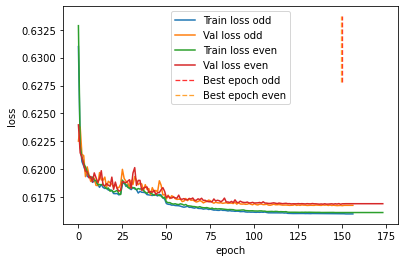

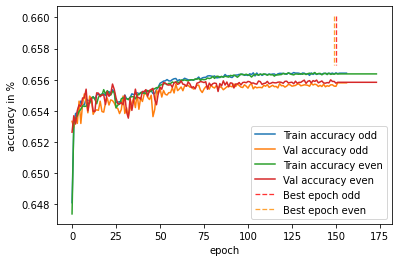

Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/architecture_odd.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/weights_odd.h5
Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/architecture_even.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/weights_even.h5


In [41]:
history_odd, model_odd, history_even, model_even= Train_Odd_Even_changed(odd, even, n_epochs = n_epochs, batch_size = batch_size)
history_list = [history_odd, history_even]
Plot_Metrics_KFold(history_list, path_SvsS) 

Save_Model(model_odd, path_tosave, "_odd")
Save_Model(model_even, path_tosave, "_even")

In [42]:
model_odd = Load_Model(path_tosave, name="_odd")
model_even = Load_Model(path_tosave, name="_even")

Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/architecture_odd.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/weights_odd.h5)
Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/architecture_even.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/weights_even.h5)


In [43]:
Predicted_even = model_odd.predict(even[0])
Predicted_odd = model_even.predict(odd[0])

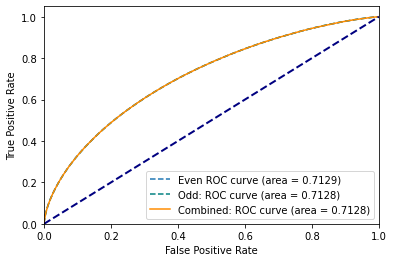

In [44]:
pred = np.concatenate([Predicted_even, Predicted_odd])
truth = np.concatenate([even[1], odd[1]])

fpr, tpr, thr = roc_curve(truth, pred)
roc_auc = auc(fpr, tpr)

fpr_even, tpr_even, thr_even = roc_curve(even[1], Predicted_even)
roc_auc_even = auc(fpr_even, tpr_even)

fpr_odd, tpr_odd, thr_odd = roc_curve(odd[1], Predicted_odd)
roc_auc_odd = auc(fpr_odd, tpr_odd)

fig = plt.figure()
plt.plot(fpr_even, tpr_even, linestyle='--', label='Even ROC curve (area = {:.4f})'.format(roc_auc_even))
plt.plot(fpr_odd, tpr_odd, linestyle='--', color='teal', label='Odd: ROC curve (area = {:.4f})'.format(roc_auc_odd))
plt.plot(fpr, tpr, color='darkorange', label='Combined: ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(path_SvsS + "ROC-Curve.png")
plt.show()

In [45]:
def Find_Eff_Cut_Equal(Sig, Bkg):
    steps = 1000
    Cut = np.linspace(0,1,steps)
    Sig_Eff_list = []
    Bkg_Eff_list = []
    for i in range(steps):    
        Sig_Eff_list.append(Sig[Sig > Cut[i]].size/Sig.size)
        Bkg_Eff_list.append(Bkg[Bkg < Cut[i]].size/Bkg.size)
    Sig_Eff_list = np.array(Sig_Eff_list)
    Bkg_Eff_list = np.array(Bkg_Eff_list)
    best_step = np.argmax(Sig_Eff_list + Bkg_Eff_list - (abs(Sig_Eff_list - Bkg_Eff_list)/2 ) )
    
    print(f"Cut_Value: {Cut[best_step]:.3f}")
    print(f"Sig_Eff: {Sig_Eff_list[best_step]:.3f}")
    print(f"Bkg_Eff: {Bkg_Eff_list[best_step]:.3f}")
    
    return Sig_Eff_list[best_step], Bkg_Eff_list[best_step], Cut[best_step]

Sig = pred[truth==1]
Bkg = pred[truth==0]
Sig_Eff, Bkg_Eff, Signal_Cut = Find_Eff_Cut_Equal(Sig=Sig, Bkg=Bkg)

Cut_Value: 0.537
Sig_Eff: 0.653
Bkg_Eff: 0.654


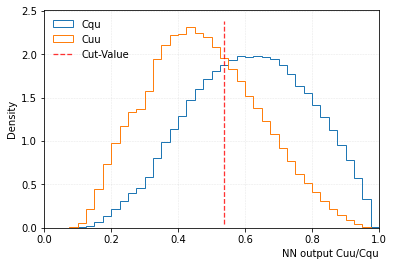

In [46]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output Cuu/Cqu", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
histargs = {"bins":40, "range":(0,1.), "density":True, "histtype":'step'}
plt.hist(pred[truth==1],label = "Cqu", **histargs)
plt.hist(pred[truth==0],label = "Cuu", **histargs)
plt.vlines(Signal_Cut, ymin=plt.gca().get_ylim()[0]+ plt.gca().get_ylim()[1]*0.02, ymax=plt.gca().get_ylim()[1]*0.98, color='red', linestyle='--', label='Cut-Value', alpha=0.8, linewidth=1.3)
plt.legend(loc='upper left', frameon=False,)
plt.savefig(path_SvsS + "DNN-Output-Signal.png")
plt.show()
#saveit = "{}/{}".format(path_tosave, "DNN_Output.png")
#plt.savefig(saveit)

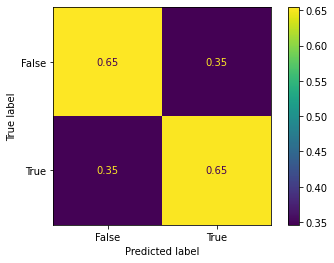

[[0.6541 0.3459]
 [0.3474 0.6526]]


In [47]:
from sklearn import metrics
pred = np.squeeze(pred)
pred_cut = np.zeros([pred.size])
pred_cut[pred > Signal_Cut] = 1
pred_cut[pred < Signal_Cut] = 0
confusion_matrix = np.round(metrics.confusion_matrix(truth, pred_cut, normalize='true'), 4)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.savefig(path_SvsS + "Confusion_Matrix.png")
plt.show()

print(confusion_matrix)

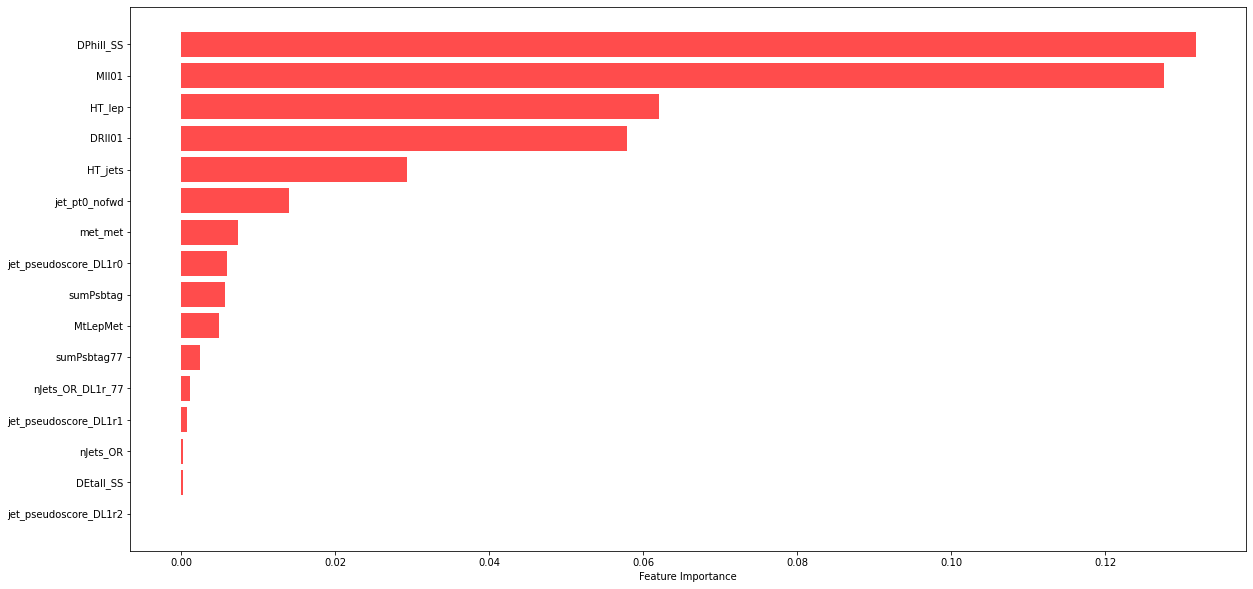

In [48]:
f, g = get_feature_importance(even, model_odd, Signal_Cut, 2)
idx = np.argsort(f)
fig, ax = plt.subplots(figsize=(20, 10))
ax.barh(range(even[0].shape[1]), np.sort(f), color="r", alpha=0.7)
ax.set_yticks(range(even[0].shape[1]), np.array(feature_names)[idx])
ax.set_xlabel('Feature Importance')
plt.savefig(path_SvsS + "/Feature_Importance_even.png")

# Test on Background

In [70]:
features_to_ignore = ["DeltaR_min_lep_bjet77", "DeltaR_max_lep_bjet77", "DRjj_lead"]
samples, feature_names, class_names, class_no = load_input_file('data/V05_sstt_Data.h5', features_to_ignore)
input_features, targets, class_labels, weights = build_combined_input(samples)

Ignoring feature:  DeltaR_min_lep_bjet77
Ignoring feature:  DeltaR_max_lep_bjet77
Ignoring feature:  DRjj_lead
Found 21 features on the dataset 18 features were loaded: 

DEtall_SS
DPhill_SS
DRll01
HT_jets
HT_lep
Mll01
MtLepMet
jet_pseudoscore_DL1r0
jet_pseudoscore_DL1r1
jet_pseudoscore_DL1r2
jet_pt0_nofwd
met_met
total_charge
nJets_OR
nJets_OR_DL1r_77
sumPsbtag
sumPsbtag77
randomRunNumber
 
Dataset contains extra labels for different backgrounds!
Class 0  :  253953
Class 1  :  231587
Class 2  :  3249
Class 3  :  310859
Class 4  :  190589
Class 5  :  223033
Class 6  :  355647
Class 7  :  109991
Class 8  :  1039
Class 9  :  0
Class 10  :  425286
Dataset contains 679239 Signal events and 1425994 Background events.


In [71]:
#Extract and drop RunNumber
feature_names = feature_names[:-1]
run_numbers = input_features[:,-1]
input_features = input_features[:,:-1]
DPhi = input_features[:,1]
feature_names.remove('total_charge')
total_charge = input_features[:,12]
input_features = np.delete(input_features, 12, 1)

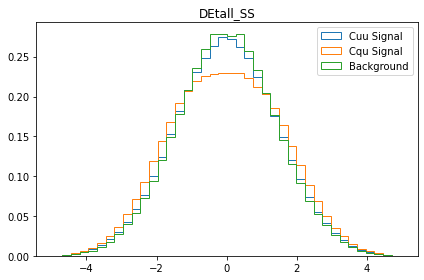

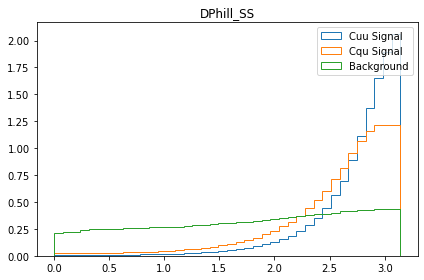

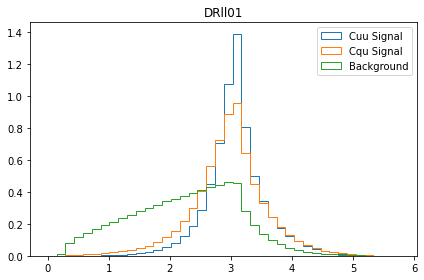

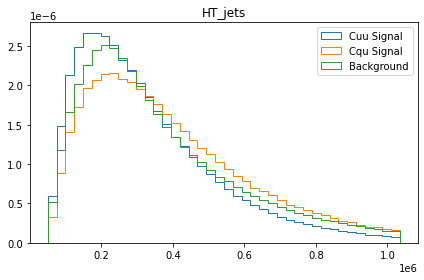

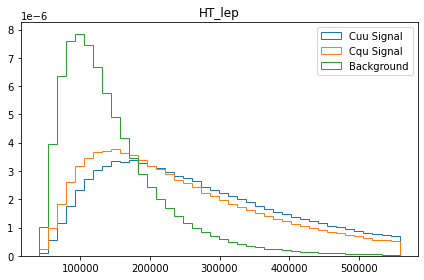

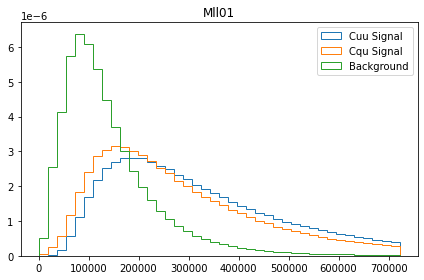

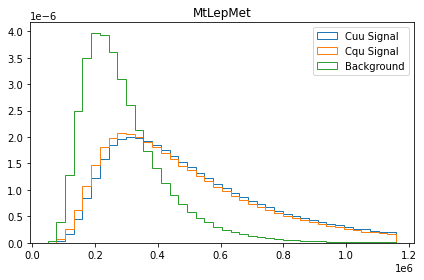

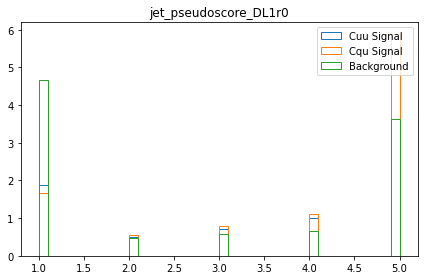

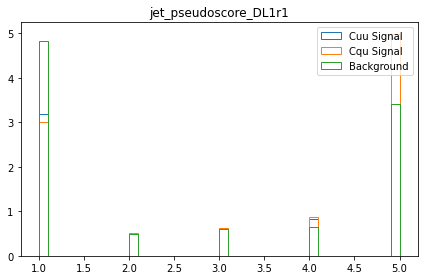

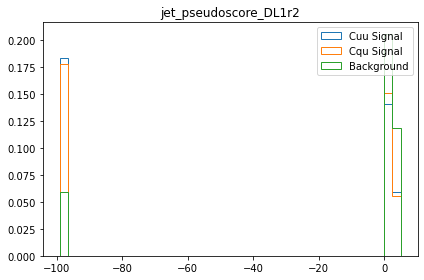

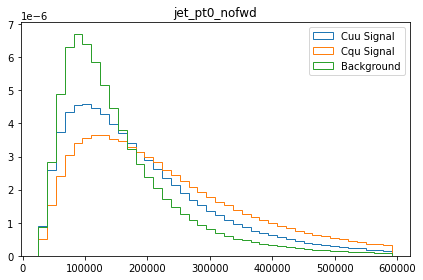

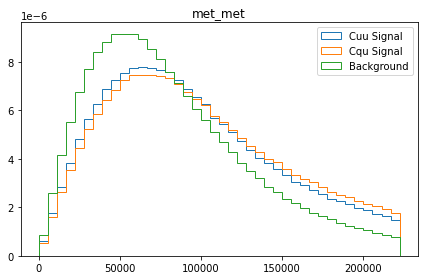

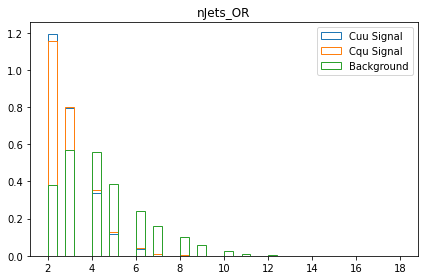

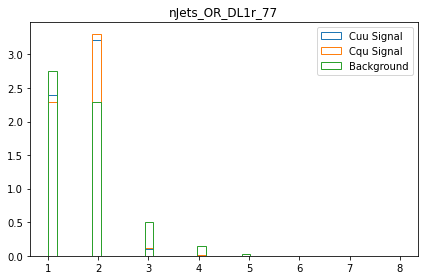

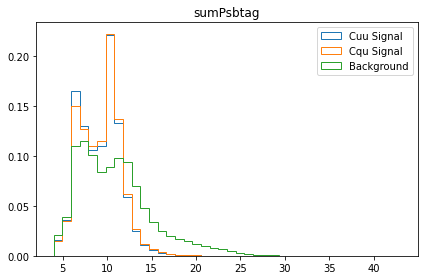

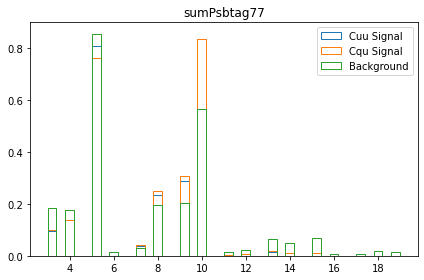

<Figure size 432x288 with 0 Axes>

In [55]:
inputs_Background = input_features[targets == 0]
histargs = {"bins":40, "density":True, "histtype":'step'}
for i in range(inputs_Signal.shape[1]):
    plt.title(feature_names[i])
    maxima = np.concatenate([inputs_Signal[:,i], inputs_Background[:,i]]).max()
    minima = np.concatenate([inputs_Signal[:,i], inputs_Background[:,i]]).min()
    if i==3:
        maxima = maxima * 0.2
    if i==4:
        maxima = maxima * 0.0025
    if i==5:
        maxima = maxima * 0.1
    if i==6:
        maxima = maxima * 0.0025
    if i==10:
        maxima = maxima * 0.2
    if i==11:
        maxima = maxima * 0.001
    if i>14:
        maxima = maxima * 0.5
    plt.hist(inputs_Signal[:,i], range=(minima, maxima), label = "Cuu Signal", **histargs, weights=weights_cuu)
    plt.hist(inputs_Signal[:,i], range=(minima, maxima), label = "Cqu Signal", **histargs, weights=weights_cqu)
    plt.hist(inputs_Background[:,i], range=(minima, maxima), label = "Background", **histargs)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig("Plots/SvsS_Input_Features/"+ feature_names[i] + ".png")
    plt.show()
    plt.clf()

In [56]:
input_scaled = scaler.transform(input_features)
odd, even = Fold_Odd_Even(input_scaled, targets, weights, class_labels, run_numbers)

In [57]:
Pred_odd = model_even.predict(odd[0])
Pred_even = model_odd.predict(even[0])

Pred = np.concatenate([Pred_odd, Pred_even])
Truth = np.concatenate([odd[1], even[1]])
Weights = np.concatenate([odd[2], even[2]])
Class_labels = np.concatenate([odd[3], even[3]])

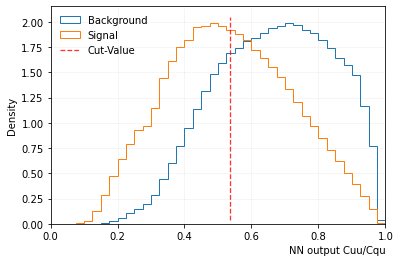

In [58]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output Cuu/Cqu", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
histargs = {"bins":40, "range":(0,1.), "density":True, "histtype":'step'}
#plt.hist(Pred[Class_labels==0], label = "tt", **histargs)
#plt.hist(Pred[Class_labels==10], label = "tbartbar", **histargs)
#plt.hist(Pred[Class_labels!=10 and Class_labels!=0], label = "Background", **histargs)
plt.hist(Pred[Truth==0], label = "Background", **histargs)
plt.hist(Pred[Truth==1], label="Signal", **histargs)
plt.vlines(Signal_Cut, ymin=plt.gca().get_ylim()[0]+ plt.gca().get_ylim()[1]*0.02, ymax=plt.gca().get_ylim()[1]*0.98, color='red', linestyle='--', label='Cut-Value', alpha=0.8, linewidth=1.3)
plt.legend(frameon=False, loc='upper left')
plt.savefig(path_SvsS + "DNN-Output-Signal-Background.png")
plt.show()

In [59]:
index_sort = np.argsort(class_no)
class_names = (np.array(class_names)[index_sort])
class_no = np.sort(class_no)

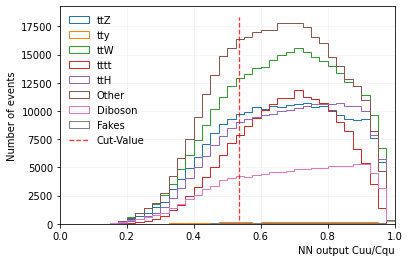

In [60]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output Cuu/Cqu", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Number of events")
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
for i in range(1,9):
    plt.hist(Pred[Class_labels == i], label = class_names[i], **histargs)
plt.vlines(Signal_Cut, ymin=plt.gca().get_ylim()[0]+ plt.gca().get_ylim()[1]*0.02, ymax=plt.gca().get_ylim()[1]*0.98, color='red', linestyle='--', label='Cut-Value', alpha=0.8, linewidth=1.3)
plt.savefig(path_SvsS + "DNN-Output-Background-classes.png")
plt.legend(frameon=False, loc='upper left')
plt.show()

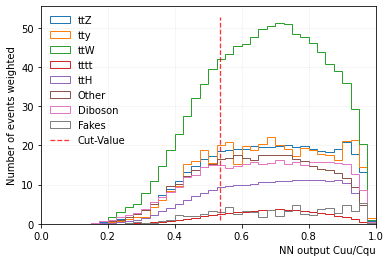

In [61]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output Cuu/Cqu", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Number of events weighted")
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
for i in range(1,9):
    plt.hist(Pred[Class_labels == i], label = class_names[i], **histargs, weights=Weights[Class_labels == i])
plt.vlines(Signal_Cut, ymin=plt.gca().get_ylim()[0]+ plt.gca().get_ylim()[1]*0.02, ymax=plt.gca().get_ylim()[1]*0.98, color='red', linestyle='--', label='Cut-Value', alpha=0.8, linewidth=1.3)
plt.legend(frameon=False, loc='upper left')
plt.savefig(path_SvsS + "DNN-Output-Background-classes_weighted.png")
plt.show()

# Split into Cuu SR & Cqu SR

In [62]:
def Split_in_SR(input_data, Predict, Signal_Cut):
    mask_cuu = np.squeeze(Predict < Signal_Cut)
    mask_cqu = np.squeeze(Predict >= Signal_Cut)
    features_cuu = input_data[0][mask_cuu,:]
    features_cqu = input_data[0][mask_cqu,:]
    targets_cuu = input_data[1][mask_cuu]
    targets_cqu = input_data[1][mask_cqu]
    weights_cuu = input_data[2][mask_cuu]
    weights_cqu = input_data[2][mask_cqu]
    class_labels_cuu = input_data[3][mask_cuu]
    class_labels_cqu = input_data[3][mask_cqu]
    cuu = (features_cuu, targets_cuu, weights_cuu, class_labels_cuu)
    cqu = (features_cqu, targets_cqu, weights_cqu, class_labels_cqu)
    return cuu, cqu

In [68]:
odd_cuu, odd_cqu = Split_in_SR(odd, Pred_odd, Signal_Cut=Signal_Cut)
even_cuu, even_cqu = Split_in_SR(even, Pred_even, Signal_Cut=Signal_Cut)

# Check DPhi Cuu Region

In [72]:
odd_total_charge = total_charge[run_numbers % 2 == 1]
even_total_charge = total_charge[run_numbers % 2 == 0]
odd_DPhi = DPhi[run_numbers % 2 == 1]
even_DPhi = DPhi[run_numbers % 2 == 0]
mask_cuu_odd = np.squeeze(Pred_odd < Signal_Cut)
mask_cqu_odd = np.squeeze(Pred_odd >= Signal_Cut)
mask_cuu_even = np.squeeze(Pred_even < Signal_Cut)
mask_cqu_even = np.squeeze(Pred_even >= Signal_Cut)
odd_cuu_total_charge = odd_total_charge[mask_cuu_odd]
odd_cqu_total_charge = odd_total_charge[mask_cqu_odd]
even_cuu_total_charge = even_total_charge[mask_cuu_even]
even_cqu_total_charge = even_total_charge[mask_cqu_even]
odd_cuu_DPhi = odd_DPhi[mask_cuu_odd]
odd_cqu_DPhi = odd_DPhi[mask_cqu_odd]
even_cuu_DPhi = even_DPhi[mask_cuu_even]
even_cqu_DPhi = even_DPhi[mask_cqu_even]
odd_cuu_SmallerDPhi = odd_cuu[0][odd_cuu_DPhi < 2.0]
odd_cuu_LargerDPhi = odd_cuu[0][odd_cuu_DPhi >= 2.0]
odd_cuu_total_charge_SmallerDPhi = odd_cuu_total_charge[odd_cuu_DPhi < 2.0]
odd_cuu_total_charge_LargerDPhi = odd_cuu_total_charge[odd_cuu_DPhi >= 2.0]
print(odd_cuu_total_charge_SmallerDPhi[odd_cuu_total_charge_SmallerDPhi == 2].shape)
print(odd_cuu_total_charge_SmallerDPhi[odd_cuu_total_charge_SmallerDPhi == 254].shape)

(5061,)
(4548,)


In [73]:
target_odd_cuu_SmallerDPhi = odd_cuu[1][odd_cuu_DPhi < 2.0]
target_odd_cuu_LargerDPhi = odd_cuu[1][odd_cuu_DPhi >= 2.0]
weights_odd_cuu_SmallerDPhi = odd_cuu[2][odd_cuu_DPhi < 2.0]
weights_odd_cuu_LargerDPhi = odd_cuu[2][odd_cuu_DPhi >= 2.0]
odd_cuu_total_charge_SmallerDPhi_pos = odd_cuu_total_charge_SmallerDPhi[odd_cuu_total_charge_SmallerDPhi == 2]
odd_cuu_total_charge_SmallerDPhi_neg = odd_cuu_total_charge_SmallerDPhi[odd_cuu_total_charge_SmallerDPhi == 254]
target_odd_cuu_SmallerDPhi_pos = target_odd_cuu_SmallerDPhi[odd_cuu_total_charge_SmallerDPhi == 2]
target_odd_cuu_SmallerDPhi_neg = target_odd_cuu_SmallerDPhi[odd_cuu_total_charge_SmallerDPhi == 254]
weights_odd_cuu_SmallerDPhi_pos = weights_odd_cuu_SmallerDPhi[odd_cuu_total_charge_SmallerDPhi == 2]
weights_odd_cuu_SmallerDPhi_neg = weights_odd_cuu_SmallerDPhi[odd_cuu_total_charge_SmallerDPhi == 254]
weights_odd_cuu_SmallerDPhi_pos_Signal =weights_odd_cuu_SmallerDPhi_pos[target_odd_cuu_SmallerDPhi_pos == 1]
weights_odd_cuu_SmallerDPhi_pos_Background =weights_odd_cuu_SmallerDPhi_pos[target_odd_cuu_SmallerDPhi_pos == 0]
weights_odd_cuu_SmallerDPhi_neg_Signal =weights_odd_cuu_SmallerDPhi_neg[target_odd_cuu_SmallerDPhi_neg == 1]
weights_odd_cuu_SmallerDPhi_neg_Background =weights_odd_cuu_SmallerDPhi_neg[target_odd_cuu_SmallerDPhi_neg == 0]

print(weights_odd_cuu_SmallerDPhi_pos_Signal.shape)
print(weights_odd_cuu_SmallerDPhi_pos_Background.shape)
print(weights_odd_cuu_SmallerDPhi_neg_Signal.shape)
print(weights_odd_cuu_SmallerDPhi_neg_Background.shape)
print(weights_odd_cuu_SmallerDPhi_pos_Signal.sum())
print(weights_odd_cuu_SmallerDPhi_pos_Background.sum())
print(weights_odd_cuu_SmallerDPhi_neg_Signal.sum())
print(weights_odd_cuu_SmallerDPhi_neg_Background.sum())

(246,)
(4815,)
(768,)
(3780,)
1.1149842416527918
10.528474767537812
0.08312872672620975
7.593438346507861


In [64]:
# Reduce to 6 features for Signal over Background NN
Wanted_Features = ['jet_pseudoscore_DL1r0', 'jet_pseudoscore_DL1r1', 'HT_lep', 'MtLepMet', 'jet_pt0_nofwd', 'nJets_OR', 'total_charge']
i = 0
Wanted_Features_idx_list = []
for feature in feature_names:
    for Wanted_Feature in Wanted_Features:    
        if feature == Wanted_Feature:
            Wanted_Features_idx_list.append(i)
    i += 1

In [65]:
def Recombine_reduced_data(input_data, input_features):
    return (input_features, input_data[1], input_data[2], input_data[3])

def Reduce_Features(input_data, feature_list, feature_names):
    features_to_delete = []
    if input_data[0].shape[1] == 6:
        print("Exit function, data is already reduced!")
        return input_data
    for i in range(input_data[0].shape[1]):
        if i not in feature_list:
            features_to_delete.append(i)
            
    features_to_delete.reverse()
    input_features = input_data[0]
    
    for feature_idx in features_to_delete:
        input_features = np.delete(input_features, feature_idx, 1)
        
    input_data = Recombine_reduced_data(input_data, input_features)
    
    return input_data

In [77]:
odd_cuu = Reduce_Features(odd_cuu, Wanted_Features_idx_list, feature_names)
even_cuu = Reduce_Features(even_cuu, Wanted_Features_idx_list, feature_names)
odd_cqu = Reduce_Features(odd_cqu, Wanted_Features_idx_list, feature_names)
even_cqu = Reduce_Features(even_cqu, Wanted_Features_idx_list, feature_names)
if len(feature_names) > len(Wanted_Features):
    feature_names = np.array(feature_names)[Wanted_Features_idx_list].tolist()

In [78]:
odd_cuu[0].shape

(355861, 6)

In [79]:
odd_cuu_total_charge.shape

(355861,)

# Charge Split

In [90]:
# Find total_charge index
#i = 0
#for feature in feature_names:
#    if feature == 'total_charge':
#        total_charge_idx = i
#    i += 1
#print("Found", feature_names[total_charge_idx], "at index", total_charge_idx)

def Split_by_Charge_old(input_data):
    input_scaled = input_data[0]
    
    # Multiply by one to counter flip which occurs due to scaling
    total_charge = input_scaled[:,total_charge_idx] * -1
    input_scaled = np.delete(input_scaled, total_charge_idx, 1)
    
    # ++
    input_scaled_pos = input_scaled[total_charge > 0]
    targets_pos = input_data[1][total_charge > 0]
    weights_pos = input_data[2][total_charge > 0]
    class_labels_pos = input_data[3][total_charge > 0]
    # --
    input_scaled_neg = input_scaled[total_charge < 0]
    targets_neg = input_data[1][total_charge < 0]
    weights_neg = input_data[2][total_charge < 0]
    class_labels_neg = input_data[3][total_charge < 0]
    
    return (input_scaled_pos, targets_pos, weights_pos, class_labels_pos), (input_scaled_neg, targets_neg, weights_neg, class_labels_neg)

def Split_by_Charge(input_data, total_charge):
    input_scaled = input_data[0]
    
    # Multiply by one to counter flip which occurs due to scaling
    total_charge[total_charge == 254] = -2
    
    # ++
    input_scaled_pos = input_scaled[total_charge > 0]
    targets_pos = input_data[1][total_charge > 0]
    weights_pos = input_data[2][total_charge > 0]
    class_labels_pos = input_data[3][total_charge > 0]
    # --
    input_scaled_neg = input_scaled[total_charge < 0]
    targets_neg = input_data[1][total_charge < 0]
    weights_neg = input_data[2][total_charge < 0]
    class_labels_neg = input_data[3][total_charge < 0]
    
    return (input_scaled_pos, targets_pos, weights_pos, class_labels_pos), (input_scaled_neg, targets_neg, weights_neg, class_labels_neg)

In [91]:
odd_cuu_pos, odd_cuu_neg = Split_by_Charge(odd_cuu, odd_cuu_total_charge)
odd_cqu_pos, odd_cqu_neg = Split_by_Charge(odd_cqu, odd_cqu_total_charge)
even_cuu_pos, even_cuu_neg = Split_by_Charge(even_cuu, even_cuu_total_charge)
even_cqu_pos, even_cqu_neg = Split_by_Charge(even_cqu, even_cqu_total_charge)

In [92]:
ScaleWeights(odd_cuu_pos[1],odd_cuu_pos[2])
ScaleWeights(even_cuu_pos[1],even_cuu_pos[2])
ScaleWeights(odd_cqu_pos[1],odd_cqu_pos[2])
ScaleWeights(even_cqu_pos[1],even_cqu_pos[2])
ScaleWeights(odd_cuu_neg[1],odd_cuu_neg[2])
ScaleWeights(even_cuu_neg[1],even_cuu_neg[2])
ScaleWeights(odd_cqu_neg[1],odd_cqu_neg[2])
ScaleWeights(even_cqu_neg[1],even_cqu_neg[2])


======Weight Statistic========================================
Weights::        W(1)=284.454, W(0)=209.557
Scaled weights:: W(1)=82138.5, W(0)=82138.5

======Weight Statistic========================================
Weights::        W(1)=276.917, W(0)=214.894
Scaled weights:: W(1)=80676, W(0)=80676

======Weight Statistic========================================
Weights::        W(1)=297.625, W(0)=643.543
Scaled weights:: W(1)=190320, W(0)=190320

======Weight Statistic========================================
Weights::        W(1)=293.66, W(0)=641.754
Scaled weights:: W(1)=182096, W(0)=182096

======Weight Statistic========================================
Weights::        W(1)=12.917, W(0)=163.662
Scaled weights:: W(1)=95792, W(0)=95792

======Weight Statistic========================================
Weights::        W(1)=12.733, W(0)=165.833
Scaled weights:: W(1)=94473, W(0)=94473

======Weight Statistic========================================
Weights::        W(1)=11.1636, W(0)=484.286

# Train SvsB NN

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               896       
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 136       
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 9   

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 00150: early stopping
Epoch 00165: early stopping


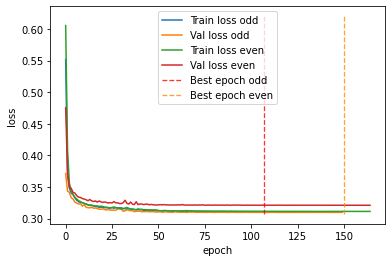

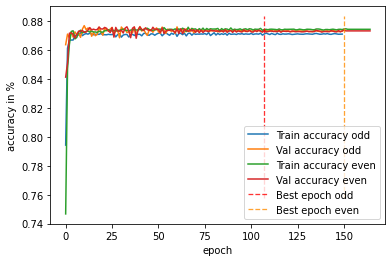

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense_30 (Dense)             (None, 128)               896       
_________________________________________________________________
dense_31 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_32 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_33 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_34 (Dense)             (None, 8)                 136       
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 9   

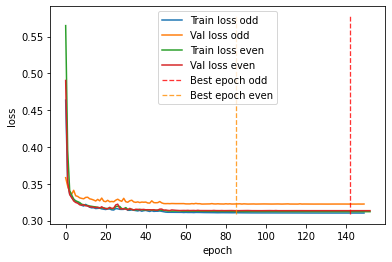

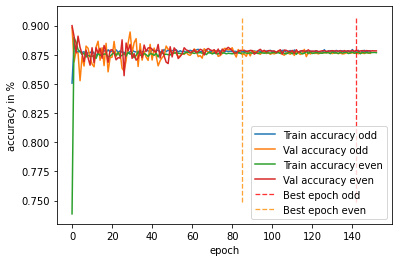

Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/architecture_odd_cuu_pos.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/weights_odd_cuu_pos.h5
Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/architecture_even_cuu_pos.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/weights_even_cuu_pos.h5
Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/architecture_odd_cqu_pos.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/weights_odd_cqu_pos.h5
Saving architecture to: /mnt/c/Users/aaro

In [93]:
hist_cuu_odd_pos, model_cuu_odd_pos, hist_cuu_even_pos, model_cuu_even_pos = Train_Odd_Even(odd_cuu_pos, even_cuu_pos, n_epochs = n_epochs, batch_size = batch_size)
history_list_cuu_pos = [hist_cuu_odd_pos, hist_cuu_even_pos]
Plot_Metrics_KFold(history_list_cuu_pos, path_SvsB, "Pos_Cuu_Models_")

hist_cqu_odd_pos, model_cqu_odd_pos, hist_cqu_even_pos, model_cqu_even_pos = Train_Odd_Even(odd_cqu_pos, even_cqu_pos, n_epochs = n_epochs, batch_size = batch_size)
history_list_cqu_pos = [hist_cqu_odd_pos, hist_cqu_even_pos]
Plot_Metrics_KFold(history_list_cqu_pos, path_SvsB, "Pos_Cqu_Models_")

Save_Model(model_cuu_odd_pos, path_tosave, "_odd_cuu_pos")
Save_Model(model_cuu_even_pos, path_tosave, "_even_cuu_pos")
Save_Model(model_cqu_odd_pos, path_tosave, "_odd_cqu_pos")
Save_Model(model_cqu_even_pos, path_tosave, "_even_cqu_pos")

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense_40 (Dense)             (None, 128)               896       
_________________________________________________________________
dense_41 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_42 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_43 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_44 (Dense)             (None, 8)                 136       
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 9   

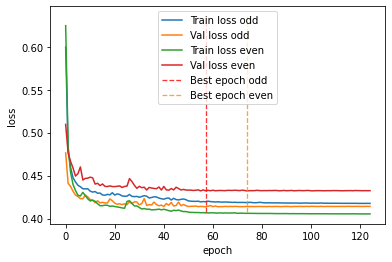

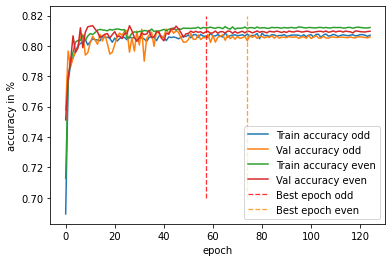

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 6)]               0         
_________________________________________________________________
dense_50 (Dense)             (None, 128)               896       
_________________________________________________________________
dense_51 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_52 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_53 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_54 (Dense)             (None, 8)                 136       
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 9  

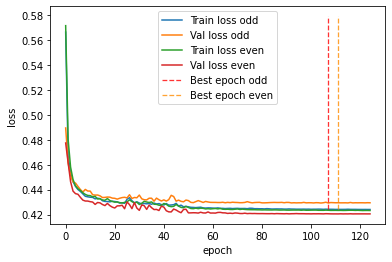

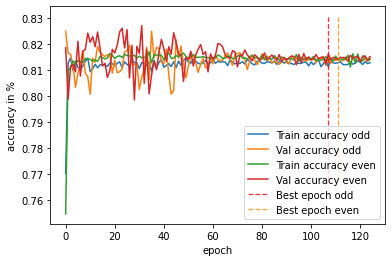

Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/architecture_odd_cuu_neg.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/weights_odd_cuu_neg.h5
Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/architecture_even_cuu_neg.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/weights_even_cuu_neg.h5
Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/architecture_odd_cqu_neg.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/weights_odd_cqu_neg.h5
Saving architecture to: /mnt/c/Users/aaro

In [94]:
n_epochs = 125
hist_cuu_odd_neg, model_cuu_odd_neg, hist_cuu_even_neg, model_cuu_even_neg = Train_Odd_Even(odd_cuu_neg, even_cuu_neg, n_epochs = n_epochs, batch_size = batch_size)
history_list_cuu_neg = [hist_cuu_odd_neg, hist_cuu_even_neg]
Plot_Metrics_KFold(history_list_cuu_neg, path_SvsB, "Neg_Cuu_Models_")

hist_cqu_odd_neg, model_cqu_odd_neg, hist_cqu_even_neg, model_cqu_even_neg = Train_Odd_Even(odd_cqu_neg, even_cqu_neg, n_epochs = n_epochs, batch_size = batch_size)
history_list_cqu_neg = [hist_cqu_odd_neg, hist_cqu_even_neg]
Plot_Metrics_KFold(history_list_cqu_neg, path_SvsB, "Neg_Cqu_Models_")

Save_Model(model_cuu_odd_neg, path_tosave, "_odd_cuu_neg")
Save_Model(model_cuu_even_neg, path_tosave, "_even_cuu_neg")
Save_Model(model_cqu_odd_neg, path_tosave, "_odd_cqu_neg")
Save_Model(model_cqu_even_neg, path_tosave, "_even_cqu_neg")

# Evaluate

In [95]:
model_cuu_even_pos = Load_Model(path_tosave, name="_even_cuu_pos")
model_cuu_odd_pos = Load_Model(path_tosave, name="_odd_cuu_pos")
model_cqu_even_pos = Load_Model(path_tosave, name="_even_cqu_pos")
model_cqu_odd_pos = Load_Model(path_tosave, name="_odd_cqu_pos")
model_cuu_even_neg = Load_Model(path_tosave, name="_even_cuu_neg")
model_cuu_odd_neg = Load_Model(path_tosave, name="_odd_cuu_neg")
model_cqu_even_neg = Load_Model(path_tosave, name="_even_cqu_neg")
model_cqu_odd_neg = Load_Model(path_tosave, name="_odd_cqu_neg")

Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/architecture_even_cuu_pos.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/weights_even_cuu_pos.h5)
Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/architecture_odd_cuu_pos.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/weights_odd_cuu_pos.h5)
Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/architecture_even_cqu_pos.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_Final_6Vars_without_Total_Charge/weights_even_cqu_pos.h5)
Loading model architecture and weights (/mnt/c/Users/aaro

In [97]:
#Reload Data to have non scaled weights
odd_cuu_pos, odd_cuu_neg = Split_by_Charge(odd_cuu, odd_cuu_total_charge)
odd_cqu_pos, odd_cqu_neg = Split_by_Charge(odd_cqu, odd_cqu_total_charge)
even_cuu_pos, even_cuu_neg = Split_by_Charge(even_cuu, even_cuu_total_charge)
even_cqu_pos, even_cqu_neg = Split_by_Charge(even_cqu, even_cqu_total_charge)

In [98]:
pred1 = model_cuu_odd_pos.predict(even_cuu_pos[0])
pred2 = model_cuu_even_pos.predict(odd_cuu_pos[0])
pred3 = model_cqu_odd_pos.predict(even_cqu_pos[0])
pred4 = model_cqu_even_pos.predict(odd_cqu_pos[0])
pred5 = model_cuu_odd_neg.predict(even_cuu_neg[0])
pred6 = model_cuu_even_neg.predict(odd_cuu_neg[0])
pred7 = model_cqu_odd_neg.predict(even_cqu_neg[0])
pred8 = model_cqu_even_neg.predict(odd_cqu_neg[0])

truth1 = even_cuu_pos[1]
truth2 = odd_cuu_pos[1]
truth3 = even_cqu_pos[1]
truth4 = odd_cqu_pos[1]
truth5 = even_cuu_neg[1]
truth6 = odd_cuu_neg[1]
truth7 = even_cqu_neg[1]
truth8 = odd_cqu_neg[1]

weights1 = even_cuu_pos[2]
weights2 = odd_cuu_pos[2]
weights3 = even_cqu_pos[2]
weights4 = odd_cqu_pos[2]
weights5 = even_cuu_neg[2]
weights6 = odd_cuu_neg[2]
weights7 = even_cqu_neg[2]
weights8 = odd_cqu_neg[2]

In [99]:
pred_cuu_pos = np.concatenate([pred1, pred2])
truth_cuu_pos = np.concatenate([truth1, truth2])
weights_cuu_pos = np.concatenate([weights1, weights2])

pred_cqu_pos = np.concatenate([pred3, pred4])
truth_cqu_pos = np.concatenate([truth3, truth4])
weights_cqu_pos = np.concatenate([weights3, weights4])

pred_cuu_neg = np.concatenate([pred5, pred6])
truth_cuu_neg = np.concatenate([truth5, truth6])
weights_cuu_neg = np.concatenate([weights5, weights6])

pred_cqu_neg = np.concatenate([pred7, pred8])
truth_cqu_neg = np.concatenate([truth7, truth8])
weights_cqu_neg = np.concatenate([weights7, weights8])

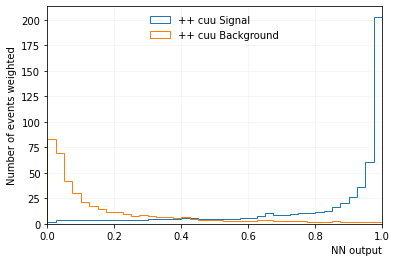

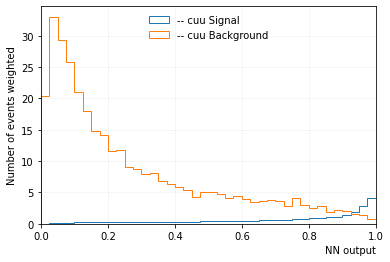

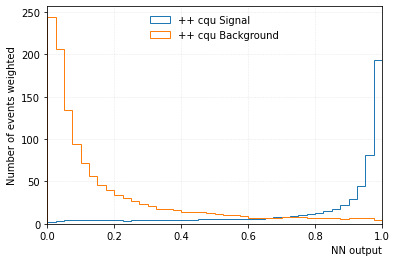

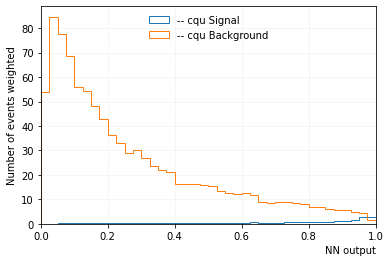

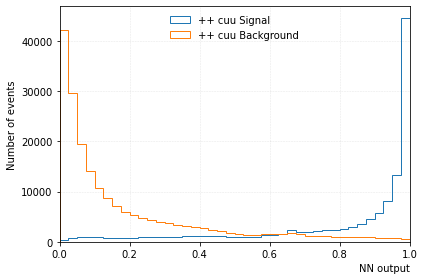

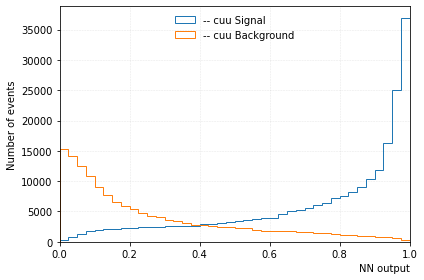

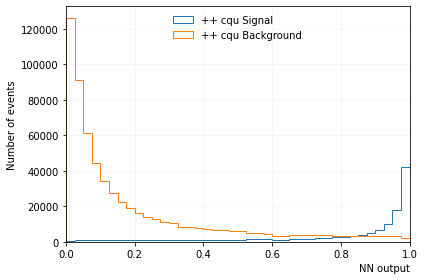

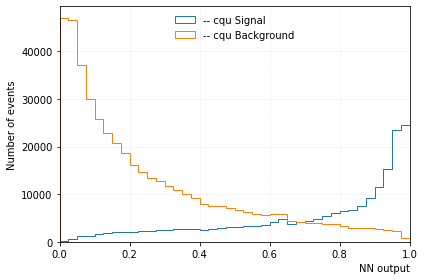

In [100]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Number of events weighted")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_cuu_pos[:,0][truth_cuu_pos==1],label = "++ cuu Signal", **histargs, weights=weights_cuu_pos[truth_cuu_pos==1])
plt.hist(pred_cuu_pos[:,0][truth_cuu_pos==0],label = "++ cuu Background", **histargs, weights=weights_cuu_pos[truth_cuu_pos==0])
plt.legend(loc='upper center', frameon=False)
plt.savefig(path_SvsB + "Pos_Cuu_DNN-Output_Weighted.png")
plt.show()

fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Number of events weighted")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_cuu_neg[:,0][truth_cuu_neg==1],label = "-- cuu Signal", **histargs, weights=weights_cuu_neg[truth_cuu_neg==1])
plt.hist(pred_cuu_neg[:,0][truth_cuu_neg==0],label = "-- cuu Background", **histargs, weights=weights_cuu_neg[truth_cuu_neg==0])
plt.legend(loc='upper center', frameon=False)
plt.savefig(path_SvsB + "Neg_Cuu_DNN-Output_Weighted.png")
plt.show()

fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Number of events weighted")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_cqu_pos[:,0][truth_cqu_pos==1],label = "++ cqu Signal", **histargs, weights=weights_cqu_pos[truth_cqu_pos==1])
plt.hist(pred_cqu_pos[:,0][truth_cqu_pos==0],label = "++ cqu Background", **histargs, weights=weights_cqu_pos[truth_cqu_pos==0])
plt.legend(loc='upper center', frameon=False)
plt.savefig(path_SvsB + "Pos_Cqu_DNN-Output_Weighted.png")
plt.show()

fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Number of events weighted")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_cqu_neg[:,0][truth_cqu_neg==1],label = "-- cqu Signal", **histargs, weights=weights_cqu_neg[truth_cqu_neg==1])
plt.hist(pred_cqu_neg[:,0][truth_cqu_neg==0],label = "-- cqu Background", **histargs, weights=weights_cqu_neg[truth_cqu_neg==0])
plt.legend(loc='upper center', frameon=False)
plt.savefig(path_SvsB + "Neg_Cqu_DNN-Output_Weighted.png")
plt.show()

fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Number of events")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_cuu_pos[:,0][truth_cuu_pos==1],label = "++ cuu Signal", **histargs)
plt.hist(pred_cuu_pos[:,0][truth_cuu_pos==0],label = "++ cuu Background", **histargs)
plt.legend(loc='upper center', frameon=False)
plt.tight_layout()
plt.savefig(path_SvsB + "Pos_Cuu_DNN-Output.png")
plt.show()

fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Number of events")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_cuu_neg[:,0][truth_cuu_neg==1],label = "-- cuu Signal", **histargs)
plt.hist(pred_cuu_neg[:,0][truth_cuu_neg==0],label = "-- cuu Background", **histargs)
plt.legend(loc='upper center', frameon=False)
plt.tight_layout()
plt.savefig(path_SvsB + "neg_Cuu_DNN-Output.png")
plt.show()

fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Number of events")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_cqu_pos[:,0][truth_cqu_pos==1],label = "++ cqu Signal", **histargs)
plt.hist(pred_cqu_pos[:,0][truth_cqu_pos==0],label = "++ cqu Background", **histargs)
plt.legend(loc='upper center', frameon=False)
plt.tight_layout()
plt.savefig(path_SvsB + "Pos_Cqu_DNN-Output.png")
plt.show()

fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Number of events")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_cqu_neg[:,0][truth_cqu_neg==1],label = "-- cqu Signal", **histargs)
plt.hist(pred_cqu_neg[:,0][truth_cqu_neg==0],label = "-- cqu Background", **histargs)
plt.legend(loc='upper center', frameon=False)
plt.tight_layout()
plt.savefig(path_SvsB + "Neg_Cqu_DNN-Output.png")
plt.show()

In [101]:
fpr1, tpr1, thr1 = roc_curve(truth_cuu_pos, pred_cuu_pos, sample_weight=weights_cuu_pos)
fpr2, tpr2, thr2 = roc_curve(truth_cuu_neg, pred_cuu_neg, sample_weight=weights_cuu_neg)
fpr3, tpr3, thr3 = roc_curve(truth_cqu_pos, pred_cqu_pos, sample_weight=weights_cqu_pos)
fpr4, tpr4, thr4 = roc_curve(truth_cqu_neg, pred_cqu_neg, sample_weight=weights_cqu_neg)

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)

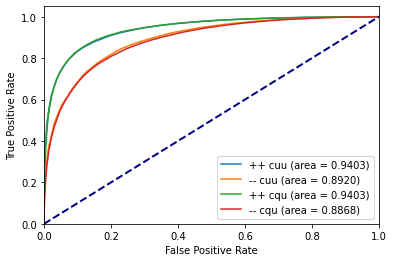

In [102]:
plt.plot(fpr1, tpr1 ,label='++ cuu (area = {:.4f})'.format(roc_auc1))
plt.plot(fpr2, tpr2 ,label='-- cuu (area = {:.4f})'.format(roc_auc2))
plt.plot(fpr3, tpr3 ,label='++ cqu (area = {:.4f})'.format(roc_auc3))
plt.plot(fpr4, tpr4 ,label='-- cqu (area = {:.4f})'.format(roc_auc4))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(path_SvsB + "ROC-Curve.png")
plt.show()